In [1]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

In [2]:
train_X = pd.read_csv("Clustered_train.csv")
train_X.drop(train_X.columns[[0]], axis=1, inplace=True)
train_X.drop('Cluster', axis=1, inplace=True)

train_Y = pd.read_csv("NAS_train.csv")
train_Y.drop(train_Y.columns[[0]], axis=1, inplace=True)

train_X = train_X.astype(float)
train_Y = train_Y.astype(int)
train_Y = (train_Y > 0)*1

In [3]:
dmatrix = xgb.DMatrix(data=train_X,label=train_Y)

In [4]:
xgb_class = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [5]:
xgb_class.fit(train_X,train_Y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [6]:
test_X = pd.read_csv("Clustered_test.csv")
test_X.drop(test_X.columns[[0]], axis=1, inplace=True)
test_X.drop('Cluster', axis=1, inplace=True)

test_Y = pd.read_csv("NAS_test.csv")
test_Y.drop(test_Y.columns[[0]], axis=1, inplace=True)

test_X = test_X.astype(float)
test_Y = test_Y.astype(int)
test_Y = (test_Y > 0)*1

In [7]:
preds = xgb_class.predict(test_X)

In [8]:
rmse = np.sqrt(mean_squared_error(test_Y, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.346516


In [9]:
params = {"objective":"reg:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [10]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.232893
Name: test-rmse-mean, dtype: float64


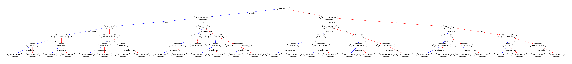

In [50]:
xgb.plot_tree(xgb_class,num_trees=0)
plt.rcParams['figure.figsize'] = (10, 40)
plt.rcParams['font.size'] = 24
plt.show()

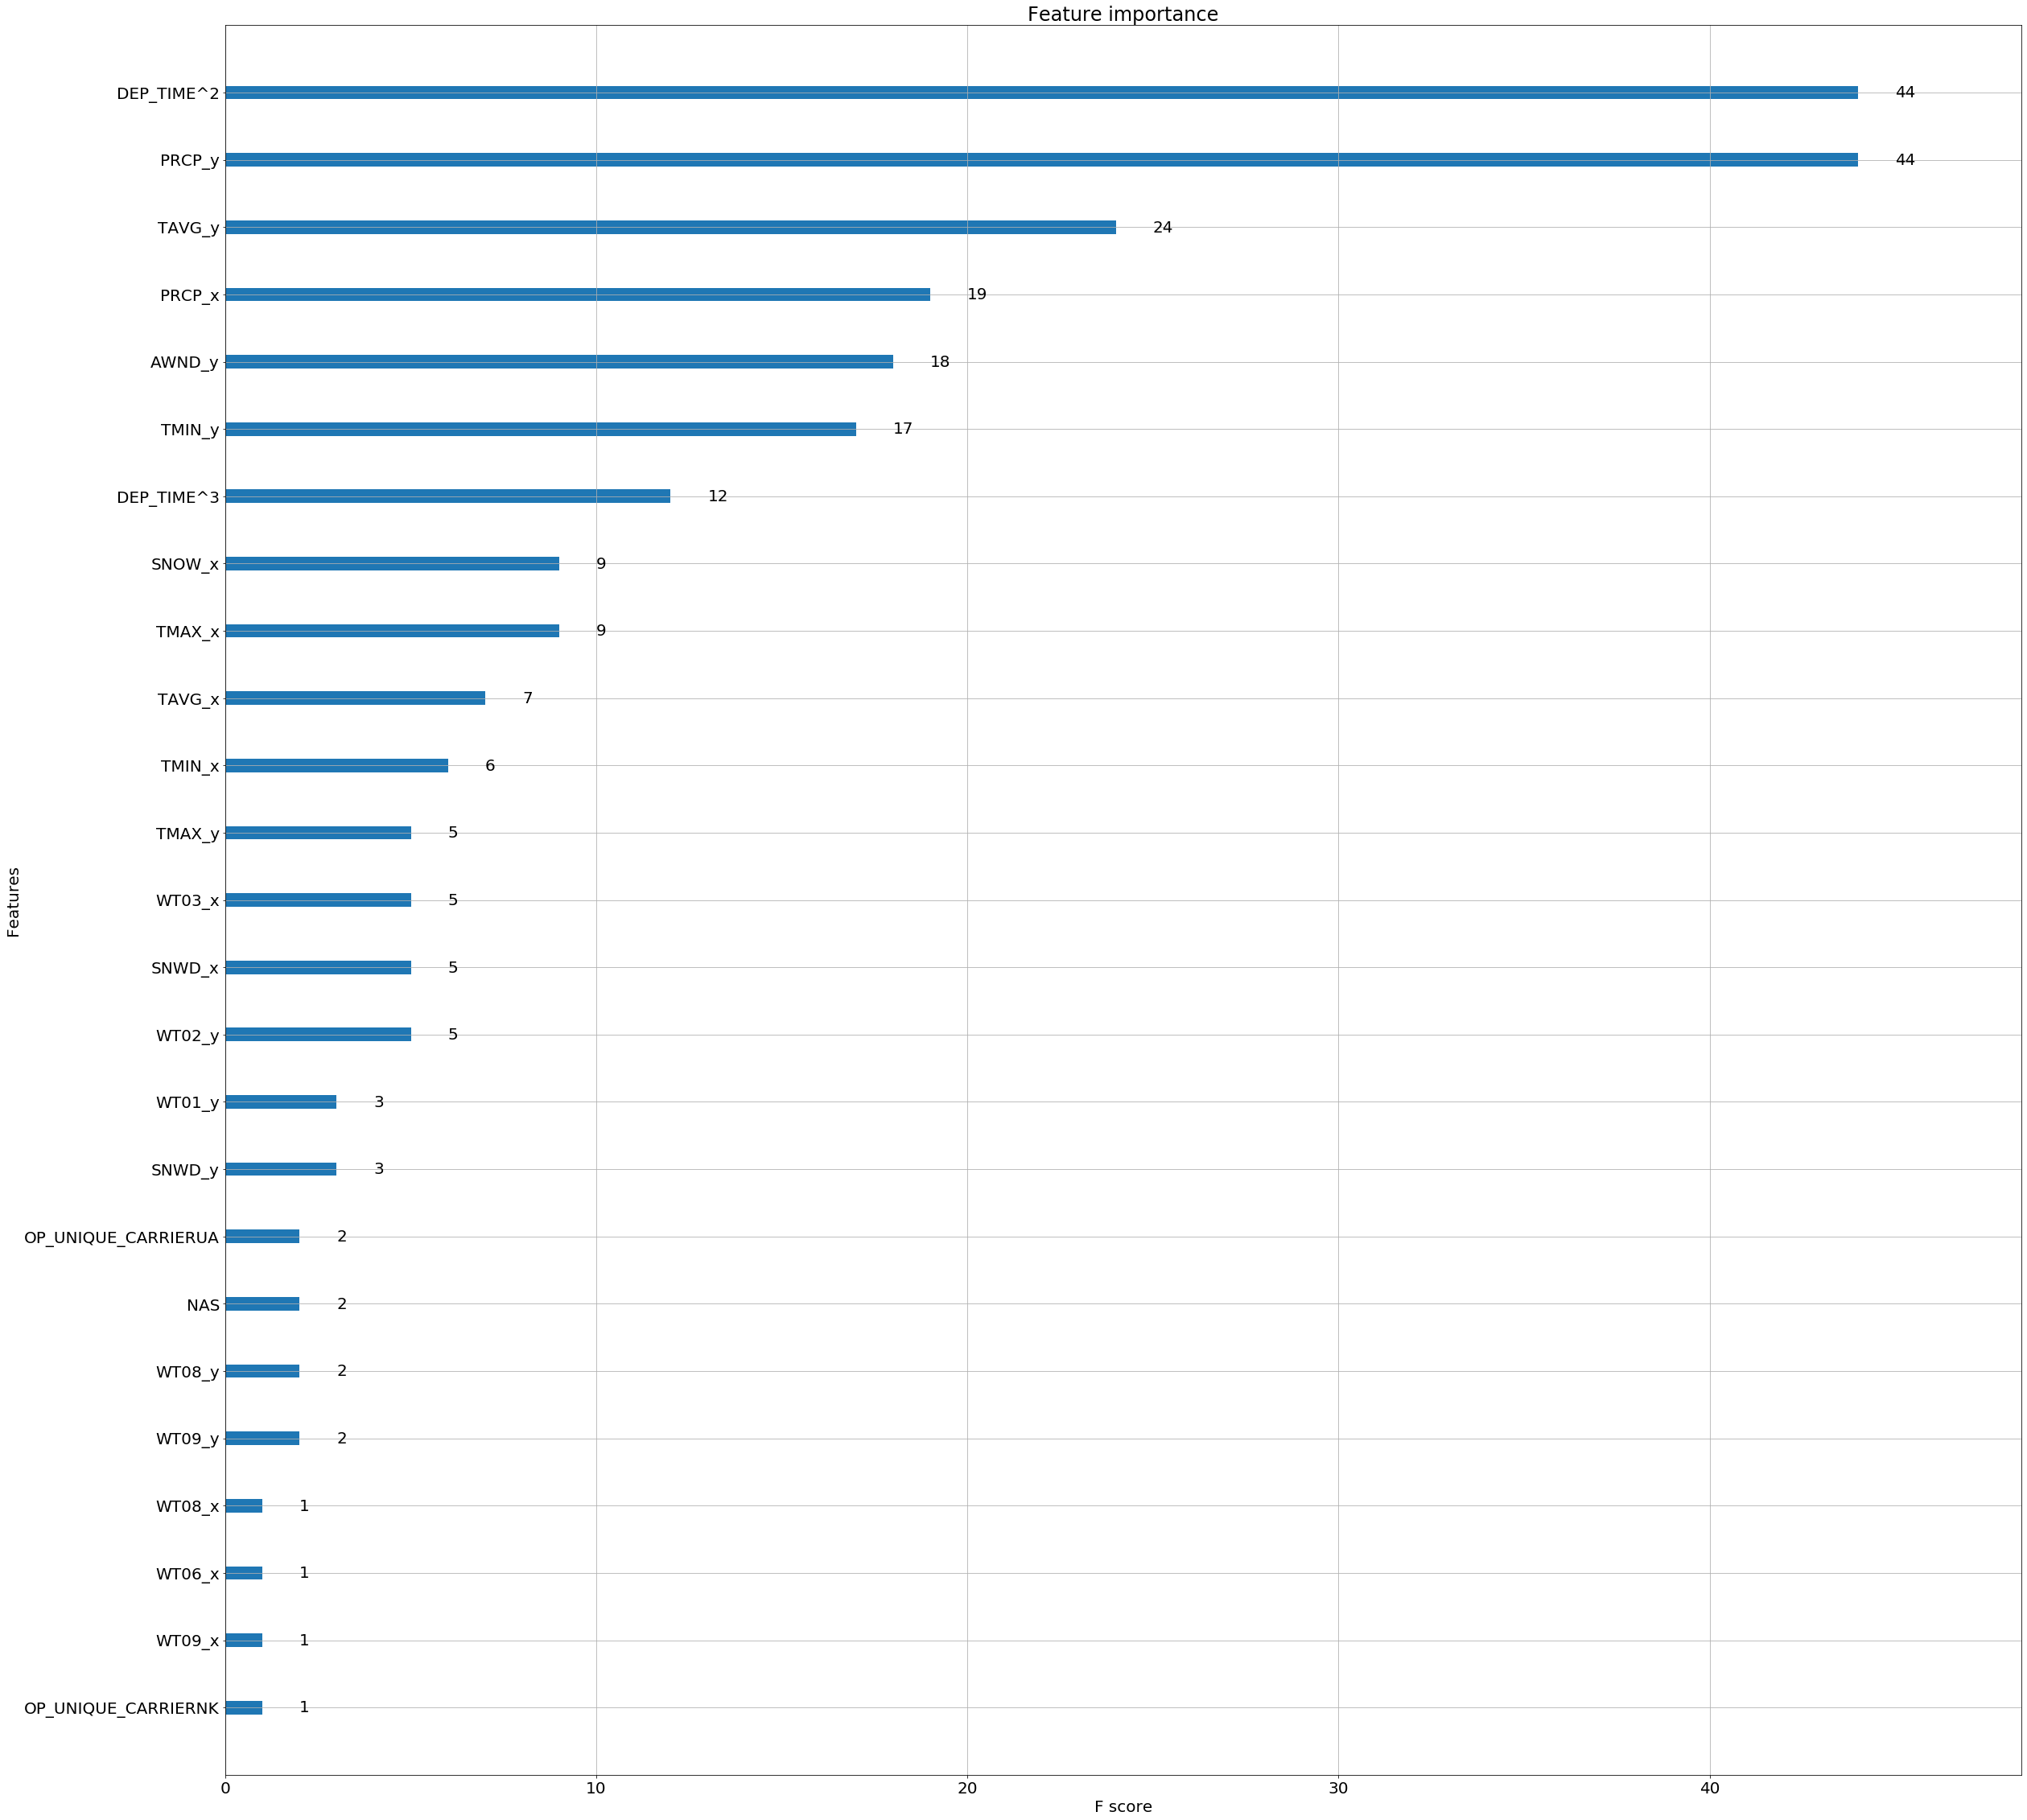

In [48]:
xgb.plot_importance(xgb_class)
plt.rcParams['figure.figsize'] = (50, 50)
plt.rcParams['font.size'] = 24
plt.show()

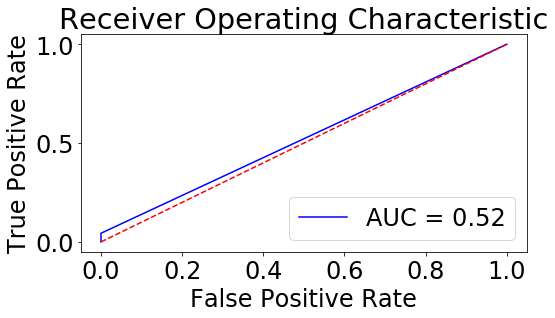

In [52]:
from sklearn import metrics
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.show()
    
buildROC(test_Y, preds)

In [59]:
print(metrics.accuracy_score(test_Y, preds))

0.8799264954785048


In [65]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(test_Y, preds)
print(confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[18082     0]
 [ 2483   114]]


In [68]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print(classification_error)
print(1 - metrics.accuracy_score(test_Y, preds))

0.12007350452149523
0.12007350452149523


In [69]:
sensitivity = TP / float(FN + TP)

print(sensitivity)
print(metrics.recall_score(test_Y, preds))

0.04389680400462072
0.04389680400462072


In [70]:
specificity = TN / (TN + FP)

print(specificity)

1.0


In [71]:
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - specificity)

0.0
0.0


In [73]:
precision = TP / float(TP + FP)

print(precision)
print(metrics.precision_score(test_Y, preds))

1.0
1.0


In [74]:
print(metrics.roc_auc_score(test_Y, preds))

0.5219484020023104
